# Import Libraries

In [1]:
!pip install spacytextblob

     |████████████████████████████████| 636 kB 929 kB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, bu

In [2]:
import pandas as pd
import re
import spacy
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline


# Define Text Preprocessing Pipeline

In [3]:
#Tokenization and dpre-processing for nlp
import string
punct = string.punctuation
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("spacytextblob")
stopwords = list(STOP_WORDS)


def text_data_cleaning(sentence):
    '''
    
    Takes a text and pre-processes it for downstream nlp
    input: single document
    output: returns a tokenised document
    
    '''
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

# Import Datasets and Models

In [4]:
#load all the classification models from one pickle
course_model= pickle.load(open('../input/classification-models-minimal/meal_model.sav', 'rb'))
diet_model= pickle.load(open('../input/classification-models-minimal/diet_model.sav', 'rb'))
cuisine_model= pickle.load(open('../input/classification-models-minimal/cuisine_model.sav', 'rb'))
# Load the sentiment analysis model
sentiment_model= pickle.load(open('../input/sentiment-models/sentiment_model.sav', 'rb'))
lsa_model =  pickle.load(open('../input/lsamodelandcorpus/LSAmodel.sav', 'rb'))
w2vec_model=  pickle.load(open('../input/word2vec/w2v_model.sav', 'rb'))

In [5]:
# import pandas as pd
# import json
# recipes=pd.read_json('../input/recipe-ingredients-dataset/train.json')
# recipes.head(1)

In [6]:
import pandas as pd
import json
business=pd.read_json('../input/yelp-businesses/yelp_academic_dataset_business.json', lines=True)
business.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None


In [7]:
# Select only restaurants from data
business['restaurant']= business.categories.str.contains(pat='Restaurants|Restaurant|food',flags=re.IGNORECASE, regex=True)
print(business[business.restaurant == True].shape)
resto = business[(business.restaurant == True) & (business.is_open == 1)]
print(resto.shape)
resto.head()

(64629, 15)
(44594, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",True
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",True
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",True


In [8]:
# Load data for labeling classifer categories
#meals= pd.read_csv("../input/labels/meal_labels.csv")
#recipe= pd.read_csv("../input/labels/recipe_labels.csv")
#tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)
#tokenizer = text_data_cleaning

In [9]:
#Pre-process the data for nlp
#recipe['diet'] =recipe['diet'].apply(tokenizer)
#recipe['cuisine'] =recipe['cuisine'].apply(tokenizer)
#meals['Food_Category']= meals['Food_Category'].apply(tokenizer)
#recipe.head()

In [10]:
# Removes nested list and creates cleaned docs in each target cell 
#recipe['diet'] = [' '.join([re.sub('[^A-Za-z]', ' ,', line) for line in lists]).strip() for lists in recipe['diet']]
#recipe['cuisine'] = [' '.join([re.sub('[^A-Za-z]', ' ,', line) for line in lists]).strip() for lists in recipe['cuisine']]
#meals['Food_Category']= [' '.join([re.sub('[^A-Za-z]', ' ,', line) for line in lists]).strip() for lists in meals['Food_Category']]
#meals.head()

In [11]:
meals= pd.read_csv("../input/tokens/Meals_token.csv")
recipe= pd.read_csv("../input/tokens/Recipe_token.csv")

In [12]:
## creating mapping from unique label texts to unique integers
labelencoderCourse = LabelEncoder()
labelencoderCourse.fit_transform(meals['Food_Category'])
labelencoderDiet = LabelEncoder()
labelencoderDiet.fit_transform(recipe['diet'])
labelencoderCuisine = LabelEncoder()
labelencoderCuisine.fit_transform(recipe['cuisine'])

array([ 6, 16,  4, ...,  8,  3, 13])

# Generate food categories using classifiers

In [13]:
#user input simulation
inputs= []
inp =['I want to eat spicy potatoes of some kind. Maybe fries.']
inpt = text_data_cleaning(' '.join(inp)) #tokenise input


In [14]:
#expand vocubulary for input
import nltk
from nltk.corpus import wordnet
#for i in inpt:
#inpput_n=text_data_cleaning(' '.join(input_nouns))
inputs=[]
for i in inpt:
    for synset in wordnet.synsets(i):
        for lem in synset.lemmas():
            #input_n.append(lem.name())
            inputs.append(lem.name()) 
#input_test= [','.join(inputs)]
input_test= [','.join(inputs)]
print(input_test)

['privation,want,deprivation,neediness,lack,deficiency,want,need,want,wish,wishing,want,desire,want,want,need,require,want,want,want,eat,eat,feed,eat,eat,eat_on,consume,eat_up,use_up,eat,deplete,exhaust,run_through,wipe_out,corrode,eat,rust,piquant,savory,savoury,spicy,zesty,hot,spicy,blue,gamy,gamey,juicy,naughty,racy,risque,spicy,potato,white_potato,Irish_potato,murphy,spud,tater,potato,white_potato,white_potato_vine,Solanum_tuberosum,kind,sort,form,variety,kind,kind,genial,kind,tolerant,possibly,perchance,perhaps,maybe,mayhap,peradventure,Fry,Roger_Fry,Roger_Eliot_Fry,Fry,Christopher_Fry,child,kid,youngster,minor,shaver,nipper,small_fry,tiddler,tike,tyke,fry,nestling,fry,fry,electrocute,fry']


In [15]:
# #keep only the nouns from the input
# import spacy
# inpt = text_data_cleaning(', '.join(input_test))
# nlp = spacy.load("en_core_web_sm")
# doc = nlp(' '.join(inpt))
# #input_nouns = []
# final_input=[]
# for chunk in doc.noun_chunks:
#     #input_nouns.append(chunk)
#     final_input.append(chunk)
#     print(chunk.text)#, chunk.root.text, chunk.root.dep_,
# #             #chunk.root.head.text)

In [16]:
# from gensim import models
# from gensim import corpora
# dictionary = corpora.Dictionary.load('../input/lsamodelandcorpus/recipe.dict')
# #transform to lsi vector spcae
# doc = ' '.join(input_test)
# vec_bow = dictionary.doc2bow(doc.lower().split())
# vec_lsi = lsa_model[vec_bow]  # convert the query to LSI space
# print(vec_lsi)

In [17]:
# from gensim import similarities
# lsi_corpus  = corpora.MmCorpus('../input/lsamodelandcorpus/recipe.mm')
# index = similarities.MatrixSimilarity(lsa_model[lsi_corpus])

In [18]:
#sims = sorted(enumerate(sims), key=lambda item: item[1])
#for doc_position, doc_score in sims:
 #   print(doc_score, rec[doc_position])


In [19]:
#our food_type classifier models on the user input
#inputs_test = final_input
predm=course_model.predict(input_test) #classifies course or meal type
predd=diet_model.predict(input_test) #classifies diet type
predc=cuisine_model.predict(input_test) #classifies cuisine type

#labels must be inverse_transformed to words for matching to our restaurant database
categories = [' '.join(labelencoderCourse.inverse_transform(predm)), ''.join(labelencoderDiet.inverse_transform(predd)), ''.join(labelencoderCuisine.inverse_transform(predc))] 
print(categories)

['appetizer', 'vegetarian', 'italian']


In [20]:
import nltk
from nltk.corpus import wordnet
#nltk.download('wordnet')
#expand the input vocubulary to improve category semantic matching
expand =[]
for cat in categories:
    print(cat)
    for synset in wordnet.synsets(cat):
        for l in synset.lemmas():
            expand.append(l.name())
print(set(expand))


appetizer
vegetarian
italian
{'vegetarian', 'starter', 'appetiser', 'appetizer', 'Italian'}


In [21]:
#create a column for cleaned and tokenised categories
resto['categories_mod']= resto.categories.apply(text_data_cleaning)
resto.head(1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant,categories_mod
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True,"[restaurants, food, bubble, tea, coffee, tea, ..."


In [22]:
#res=resto['categories_mod']
#res[0:5]
res=resto['categories_mod']
res[0:5]

3     [restaurants, food, bubble, tea, coffee, tea, ...
4                           [brewpubs, breweries, food]
5     [burger, fast, food, sandwiches, food, ice, cr...
9     [ice, cream, frozen, yogurt, fast, food, burge...
11        [vietnamese, food, restaurants, food, trucks]
Name: categories_mod, dtype: object

In [23]:
# from collections import defaultdict
# frequency = defaultdict(int)
# for text in res:
#     for token in text:
#         frequency[token] += 1

# texts = [
#     [token for token in text if frequency[token] > 1]
#     for text in res
# ]


In [24]:
resto=resto.reset_index() #index has to be reset 
resto.head()

,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant,categories_mod
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True,"[restaurants, food, bubble, tea, coffee, tea, ..."
1,4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True,"[brewpubs, breweries, food]"
2,5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",True,"[burger, fast, food, sandwiches, food, ice, cr..."
3,9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",True,"[ice, cream, frozen, yogurt, fast, food, burge..."
4,11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",True,"[vietnamese, food, restaurants, food, trucks]"


In [25]:
#create corpus
from gensim import corpora
dictionary = corpora.Dictionary(res)
dictionary.save('./categories.dict')  # store the dictionary, for future reference


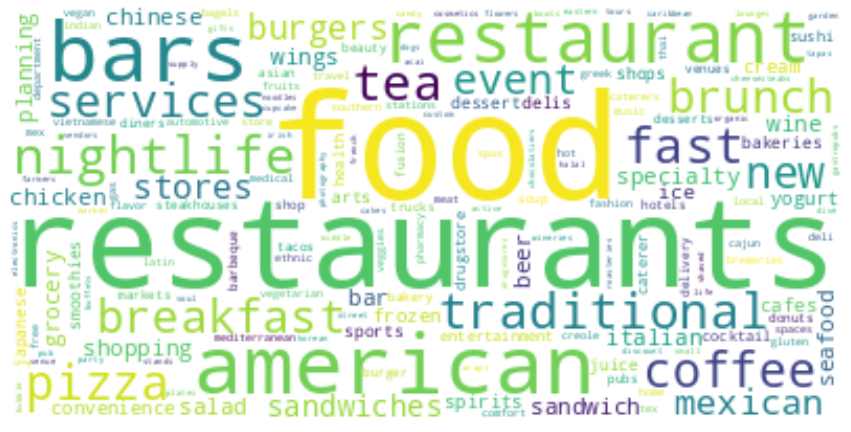

In [26]:
#Checking the most common words in our data
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(resto['categories_mod'])).value_counts()[:]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)
resto['categories_mod'].head()
plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
#dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
#print (dict_tokens)

In [28]:
#create Bag-Of-Words  i.e vectorise the corpus
cat_corpus = [dictionary.doc2bow(text) for text in res]

#check out some words frequencies
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in cat_corpus[0:3]] #limit number to print
print(word_frequencies)


[[('bakery', 1), ('bubble', 1), ('coffee', 1), ('food', 1), ('restaurants', 1), ('tea', 2)], [('food', 1), ('breweries', 1), ('brewpubs', 1)], [('food', 2), ('restaurants', 1), ('burger', 1), ('cream', 1), ('fast', 1), ('frozen', 1), ('ice', 1), ('sandwiches', 1), ('yogurt', 1)]]


In [29]:
corpora.MmCorpus.serialize('./categories.mm', cat_corpus)  # store corpus to disk, for later use
print(cat_corpus[-5:-1])

[[(2, 1), (3, 1), (5, 1), (13, 1), (27, 1), (55, 1), (57, 1)], [(2, 1), (3, 1), (4, 1), (5, 1), (23, 1), (58, 1), (60, 1), (278, 1)], [(2, 2), (3, 2), (5, 1), (41, 1), (158, 1)], [(27, 1), (95, 1)]]


In [30]:
#Train tfdif and lsi model for semantic search
import gensim
import pickle
tfidf_model = gensim.models.TfidfModel(cat_corpus, id2word=dictionary)
filename = 'tfidf_model.sav'
pickle. dump(tfidf_model, open(filename, 'wb'))
lsi_model = gensim.models.LsiModel(tfidf_model[cat_corpus], id2word=dictionary)
filename = 'lsi_model.sav'
pickle. dump(lsi_model, open(filename, 'wb'))
gensim.corpora.MmCorpus.serialize('tfidf_model_mm', tfidf_model[cat_corpus]) #save corpus
gensim.corpora.MmCorpus.serialize('lsi_model_mm',lsi_model[tfidf_model[cat_corpus]]) #save corpus


In [31]:
#load indexed corpus
tfidf_corpus = gensim.corpora.MmCorpus('tfidf_model_mm')
lsi_corpus = gensim.corpora.MmCorpus('lsi_model_mm')

# Match Generated Categories to our database
Now that we have user preferences, we use them to select restaurants to run sentiment analysis on.

In [32]:
#generate a similarity matrix
from gensim.similarities import MatrixSimilarity
business_index = MatrixSimilarity(lsi_corpus, num_features = lsi_corpus.num_terms)

In [33]:
from operator import itemgetter
tokenizer = text_data_cleaning
def search_similar(search_term):

    query_bow = dictionary.doc2bow(tokenizer(search_term))
    query_tfidf = tfidf_model[query_bow]
    query_lsi = lsi_model[query_tfidf]

    business_index.num_best = 50 #get the 50 most similar categories to our query

    business_list = business_index[query_lsi]

    business_list.sort(key=itemgetter(1), reverse=True)
    business_names = []

    for j, business in enumerate(business_list):

        business_names.append (
            {
                'Relevance': round((business[1] * 100),2),
                'business_id': resto['business_id'][business[0]],
                'categories': resto['categories_mod'][business[0]]
            }

        )
        if j == (business_index.num_best-1):
            break

    return pd.DataFrame(business_names, columns=['Relevance','business_id','categories'])


In [34]:
# query_bow = dictionary.doc2bow(tokenizer(''.join(input_test)))
# query_tfidf = tfidf_model[query_bow]
# query_lsi = lsi_model[query_tfidf]

# business_index.num_best = 5
# business_list = business_index[query_lsi]
# business_list

In [35]:
# business_list.sort(key=itemgetter(1), reverse=True)
# business_names = []

# for j, business in enumerate(business_list):

#      business_names.append (
#             {
#                 'Relevance': round((business[1] * 100),2),
#                 'business_id': resto['business_id'][business[0]],
#                 'categories': resto['categories_mod'][business[0]]
#             }

#         )
# business_names

#### The categories above are the user preferences that we use to choose restaurants to do sentiment analysis on. This isn't the final output of the pipeline.

In [36]:
# search for movie tiles that are related to below search parameters
search_similar(' '.join(categories))

,Relevance,business_id,categories
0,91.27,f7S0WFDy_J1TGahYhnoMLA,"[pizza, restaurants, italian, vegetarian]"
1,80.00,LtLbT776NOAjva1ttA2h3w,"[restaurants, pizza, vegetarian, salad, italian]"
2,76.37,7AV88DN083bPNmNue2my4Q,"[vegetarian, restaurant]"
3,74.74,4PXVOfKw7kzKq3mS4DGwYg,"[vegetarian, vegan, italian, restaurants]"
4,73.75,rEyTFs9o-xdXR-DMCLBiyg,"[restaurants, pizza, vegetarian]"
5,70.75,OT9SZuEFV-7lVMCcsZmb6Q,"[restaurants, burgers, vegetarian]"
6,70.75,Q5gW8CA-IKGeb_hFjzJGKQ,"[vegetarian, restaurants, burgers]"
7,70.66,UPP2p7oGUrOfZ919RZqVIQ,"[restaurant, vegetarian, italian, seafood, foo..."
8,70.59,dHpHptXgn1gpuxr_4DrMYQ,"[mexican, restaurants, vegetarian]"
9,69.98,SHk_eYKzIOPvgwvTThtXiQ,"[american, traditional, vegetarian, restaurants]"


# Run Sentiment Analysis
Having filtered the dataset to onyl include the categories of interest, we run a sentiment anlysis on the reviews of the selected data and add a sentiment score for each review.

# Pick 5 Best Restaurants

## Best sentiment + Average Rating
This  parts needs to select the restaurants with the best sentiment score and higest avergae rating and rank them. Then output only top five.